In [2]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.signal_classes import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_samples_from_folder
from copy import deepcopy
import pandas as pd
from lib.features import WPTFeatureExtractor, PCAModel

In [3]:
plt.style.use('default')

In [4]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

In [5]:
valid_date = datetime(2023, 1, 7, 10, 00)

dataset_per_cable = get_samples_from_folder(PATH_TO_DATASET_2, valid_date)

  0%|          | 0/4420 [00:00<?, ?it/s]

100%|██████████| 4420/4420 [01:12<00:00, 61.33it/s]


# Visualization

In [6]:
x = dataset_per_cable["c1"][["y", "z"]].to_numpy()
dates = dataset_per_cable["c1"].index.to_numpy()
y = dataset_per_cable["c1"][["tension"]].to_numpy().flatten()

del dataset_per_cable

/tmp/ipykernel_466/1104388339.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(y, np.arange(test.shape[1]), test.T, cmap="seismic")


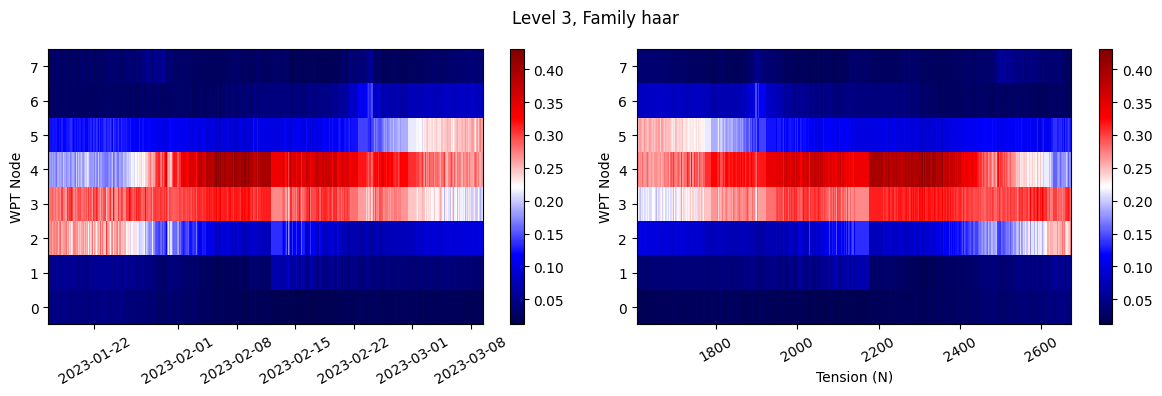

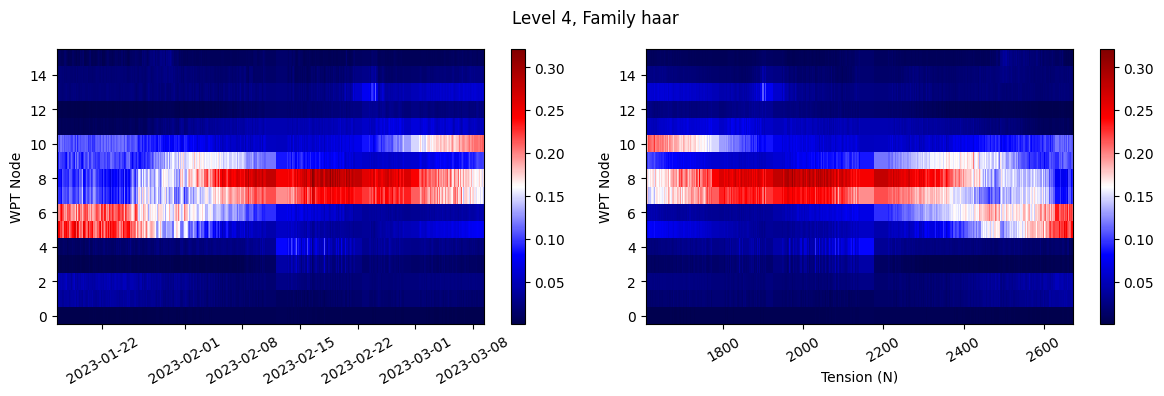

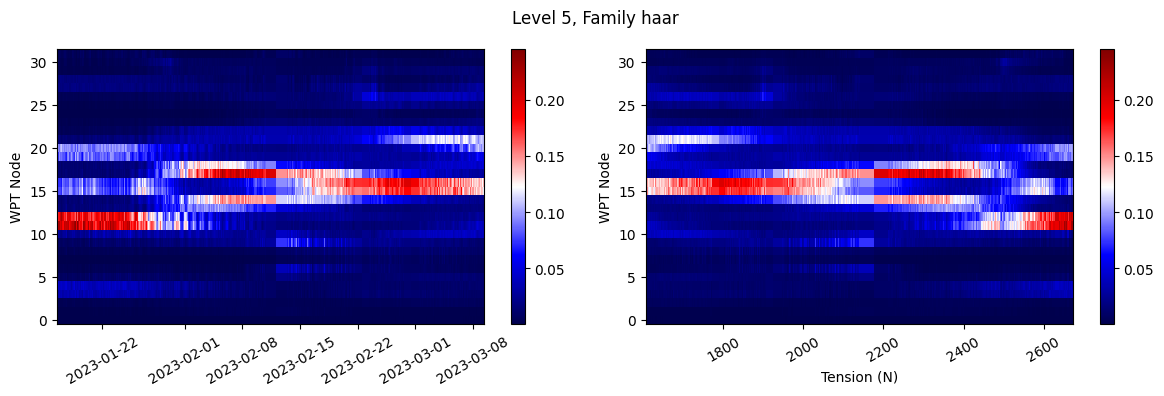

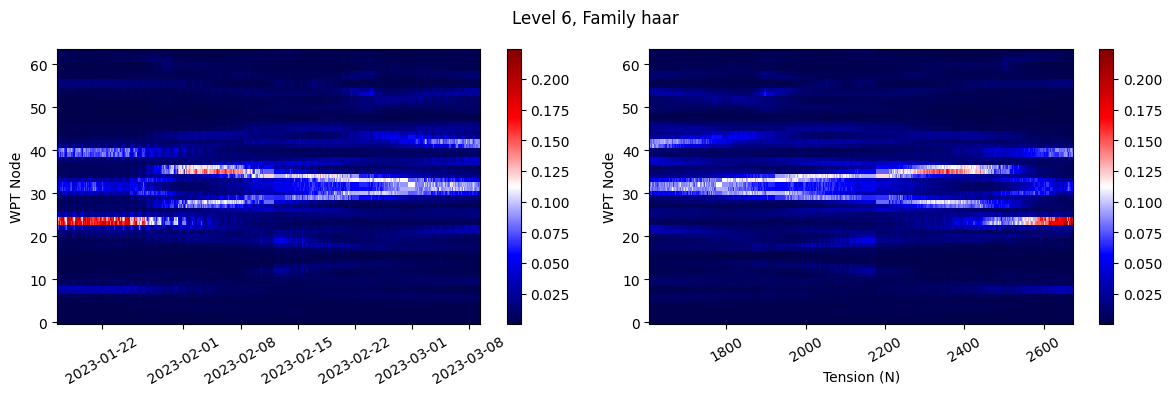

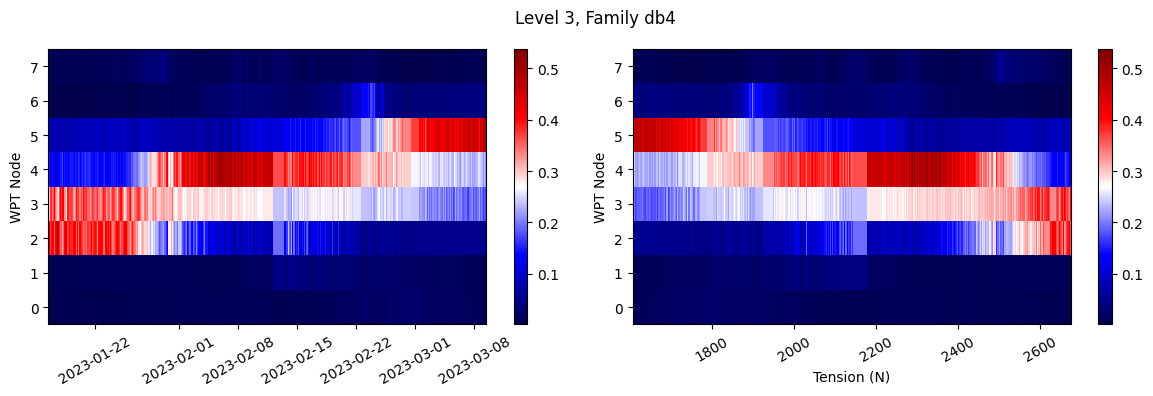

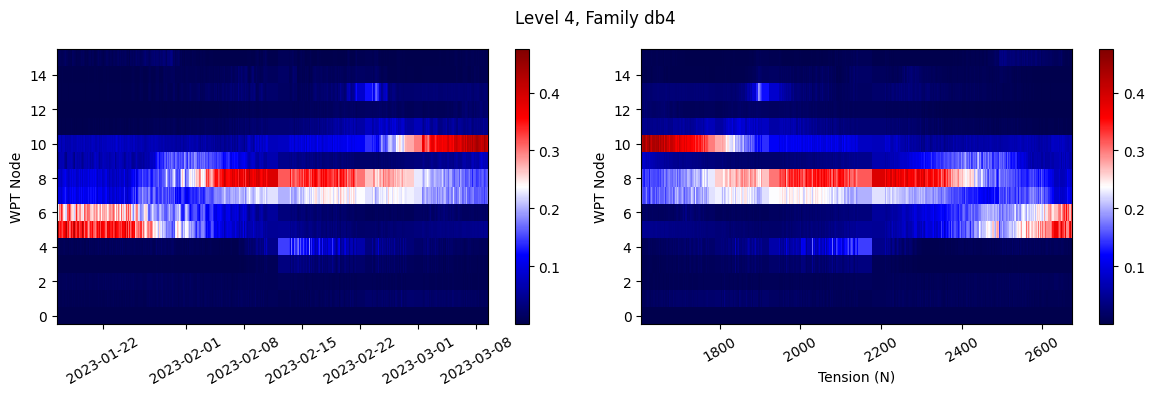

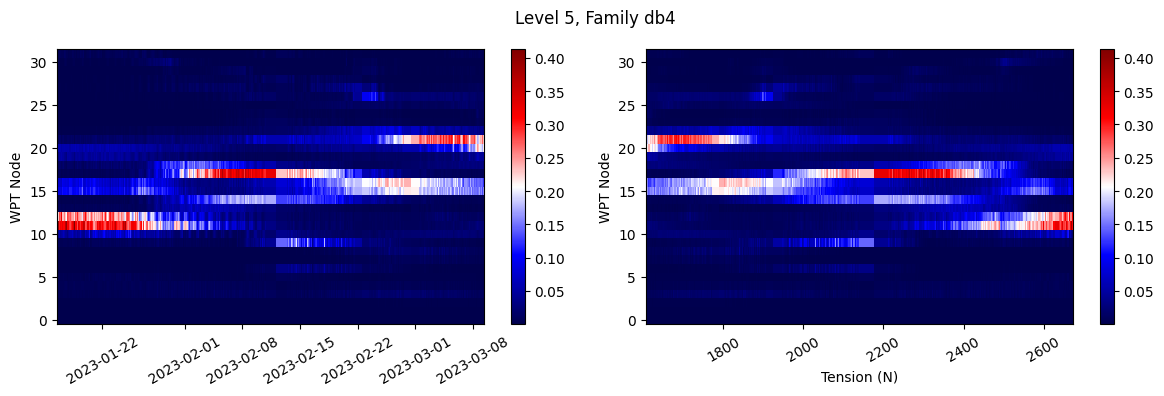

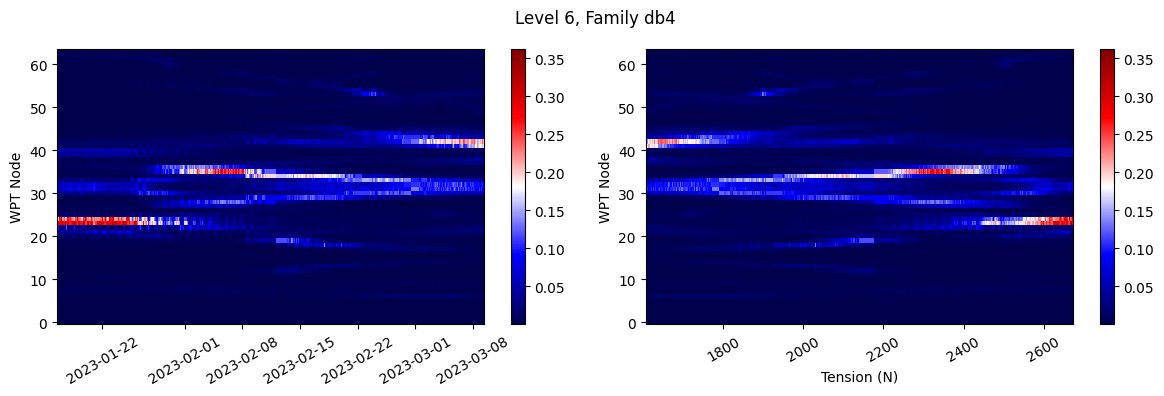

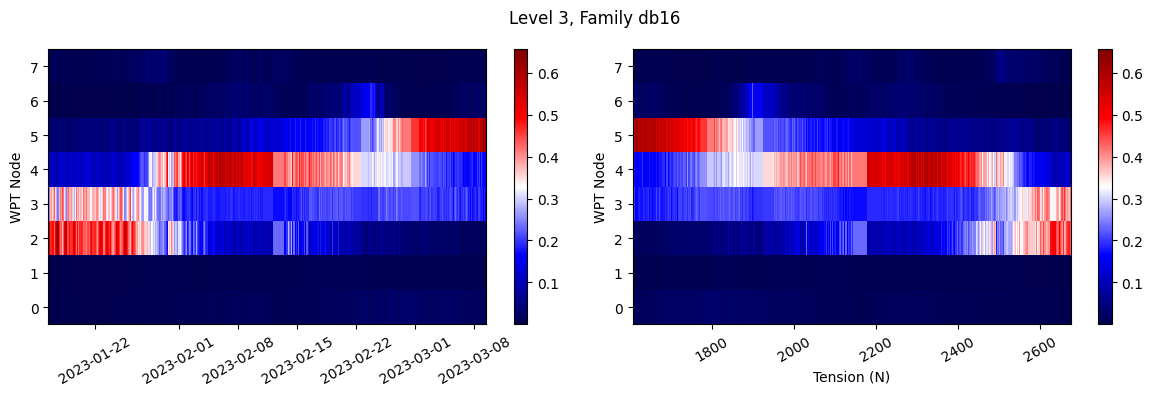

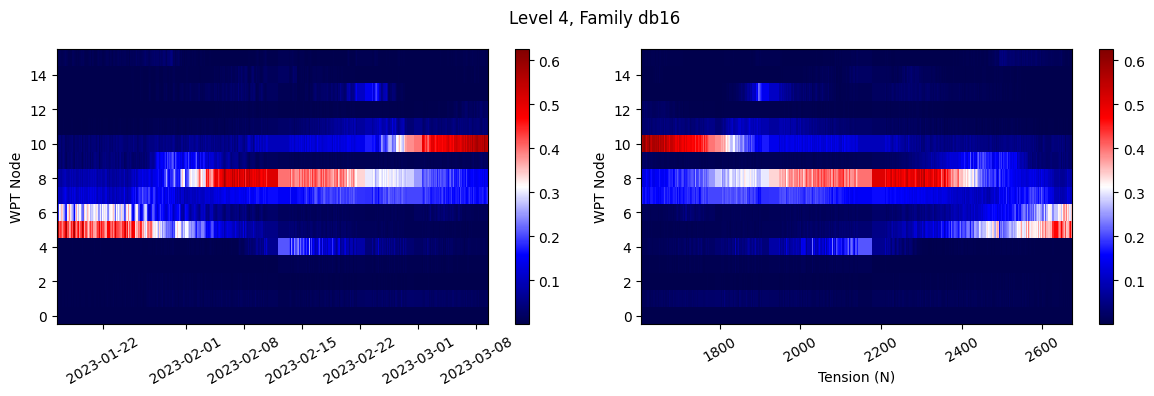

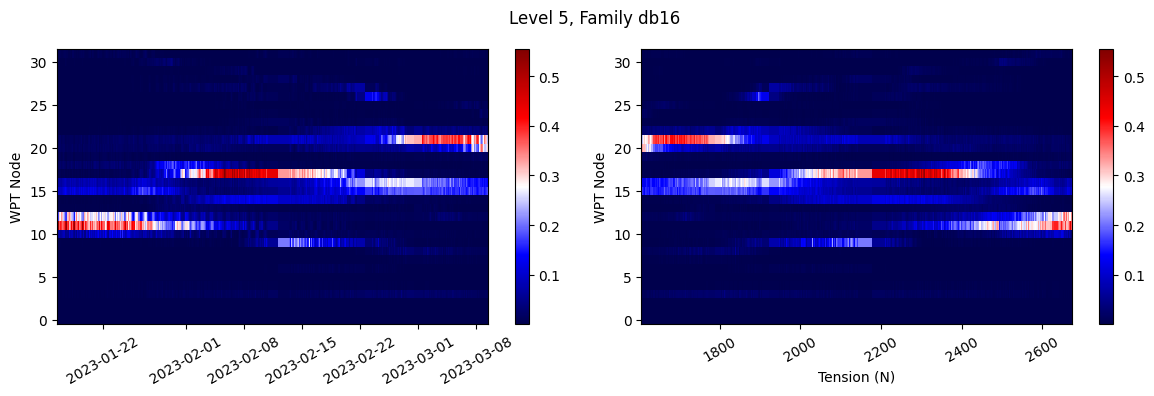

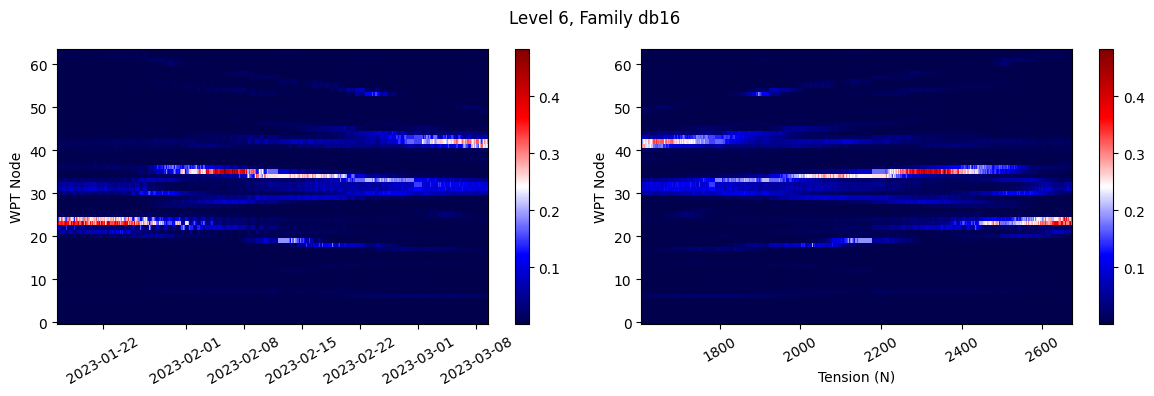

In [7]:
for family in ["haar", "db4", "db16"]:
    for level in range(3,7):
        plt.figure(figsize=(12,4))
        fe = WPTFeatureExtractor(level=level, family=family, reduction="energy", normalize=True)
        test = fe.transform(x)

        plt.subplot(1,2,1)
        plt.pcolormesh(dates, np.arange(test.shape[1]), test.T, cmap="seismic")
        plt.xticks(rotation=30);
        plt.ylabel("WPT Node");
        plt.colorbar();

        plt.subplot(1,2,2)
        plt.pcolormesh(y, np.arange(test.shape[1]), test.T, cmap="seismic")
        plt.xticks(rotation=30);
        plt.ylabel("WPT Node");
        plt.xlabel("Tension (N)");
        plt.colorbar();
        plt.suptitle(f"Level {level}, Family {family}")
        plt.tight_layout()

Thresholding

/tmp/ipykernel_466/2199224165.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(y, np.arange(test.shape[1]), test.T, cmap="seismic")


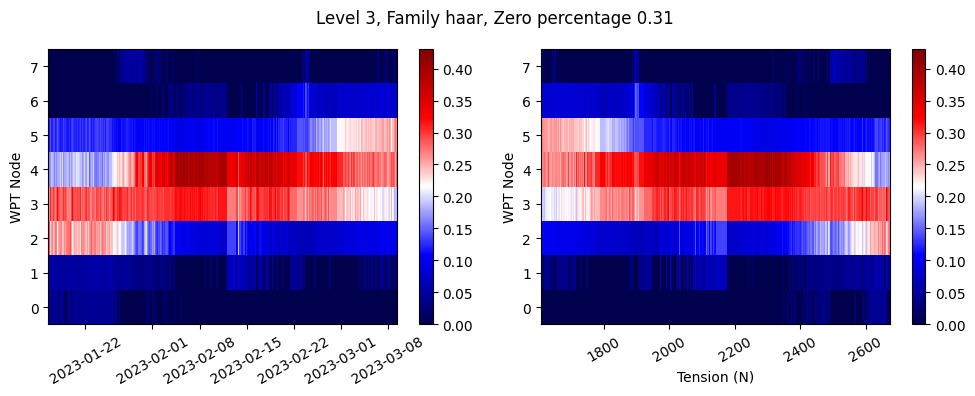

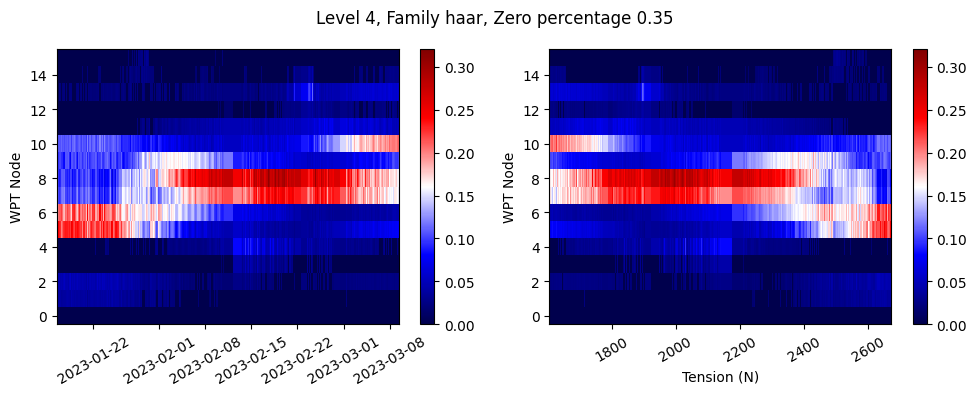

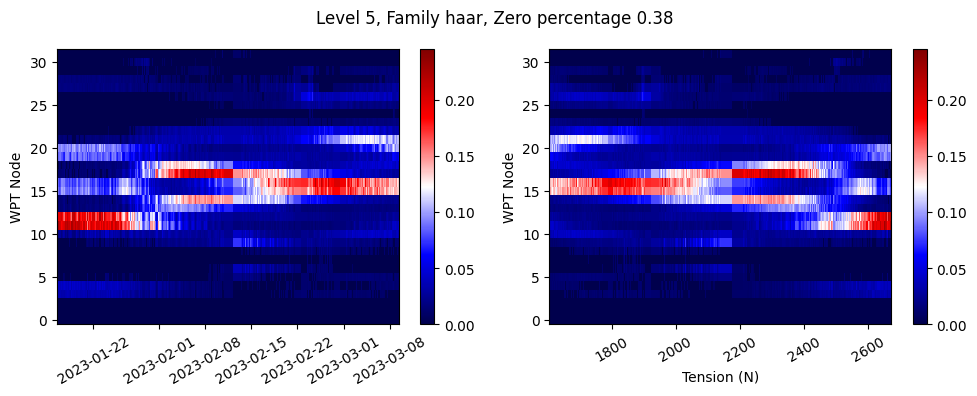

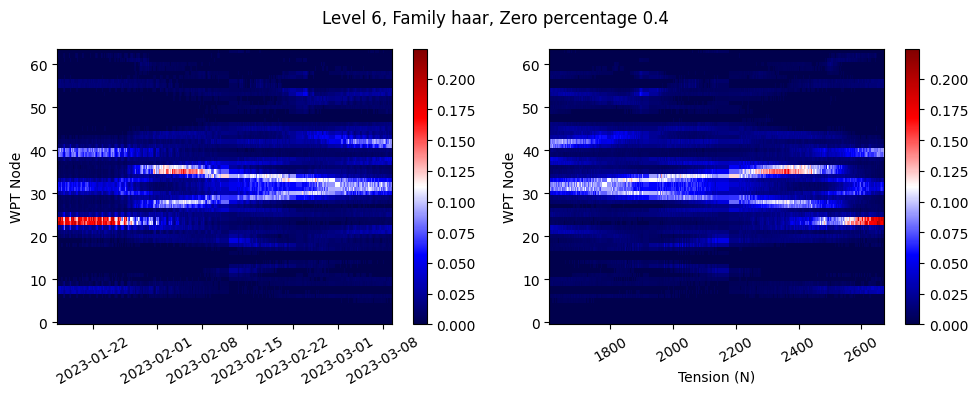

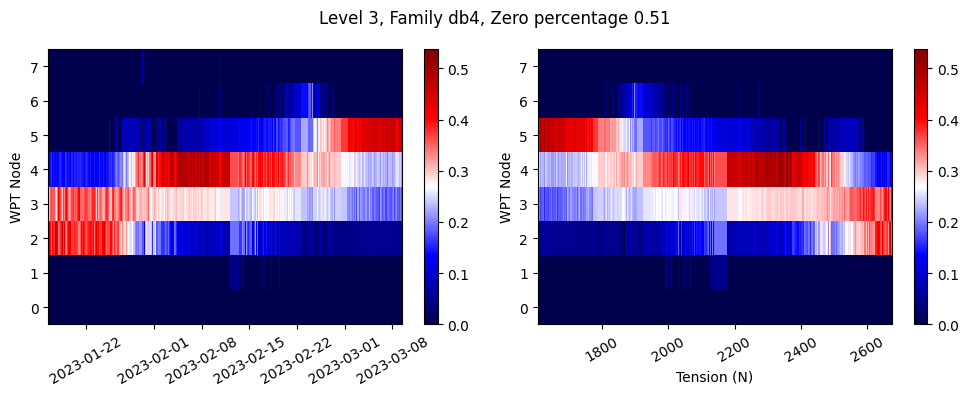

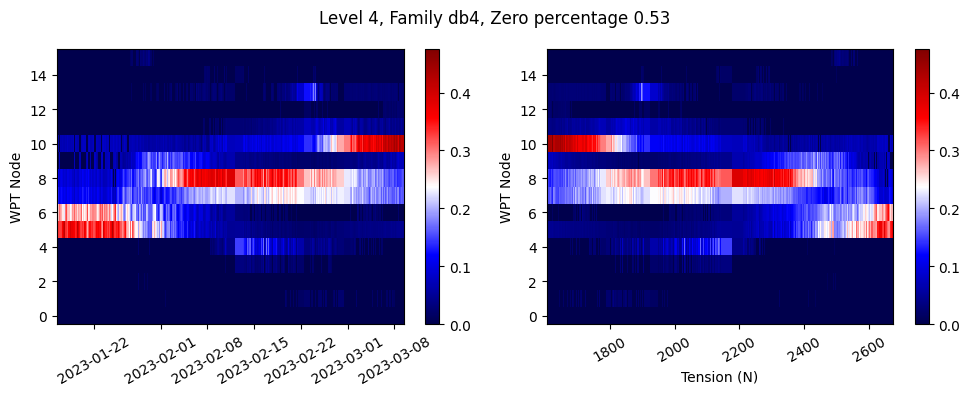

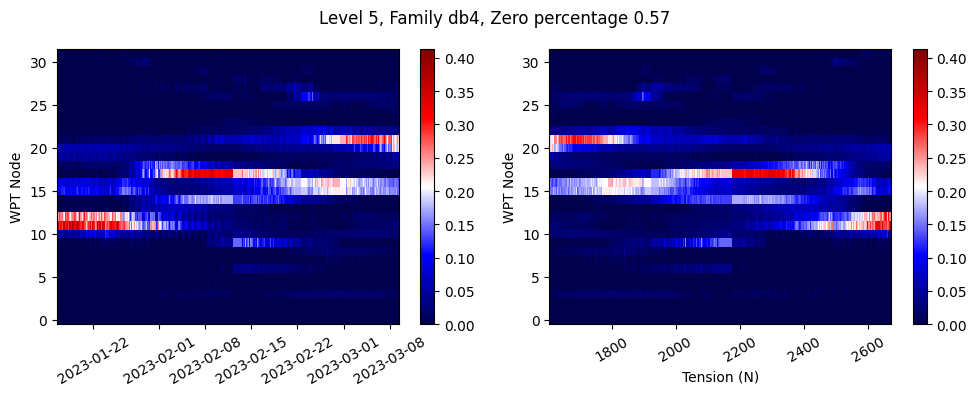

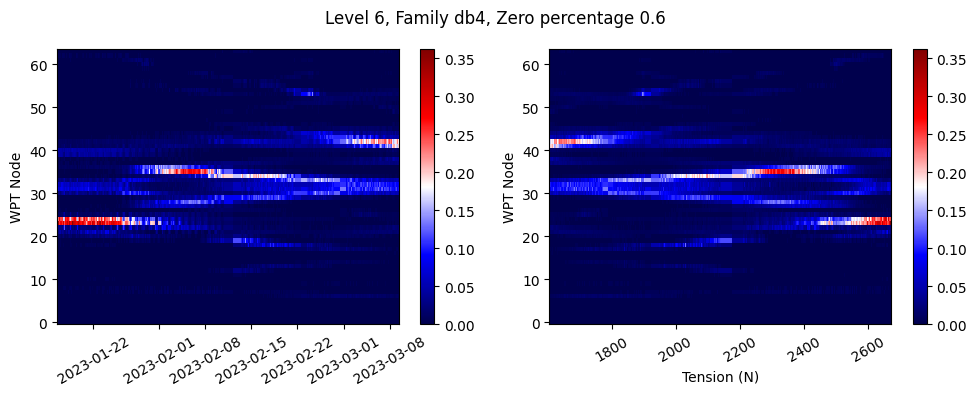

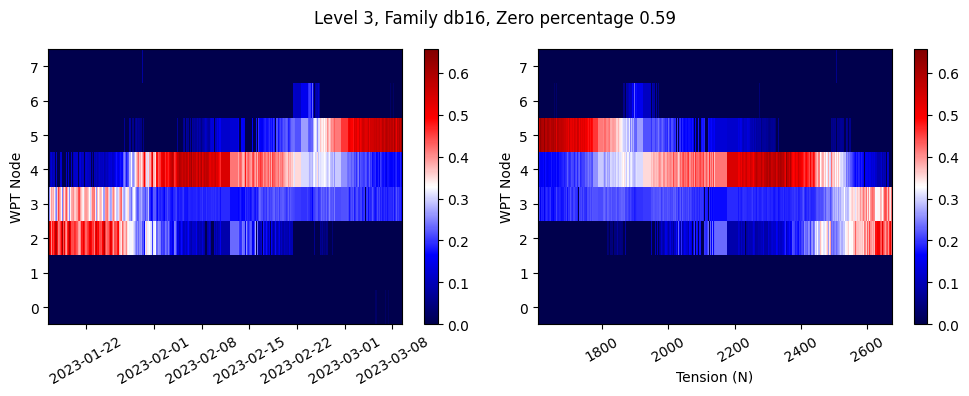

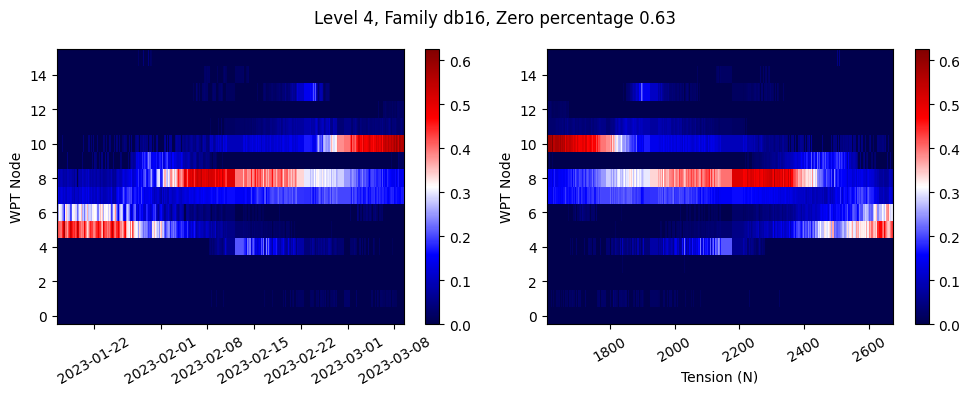

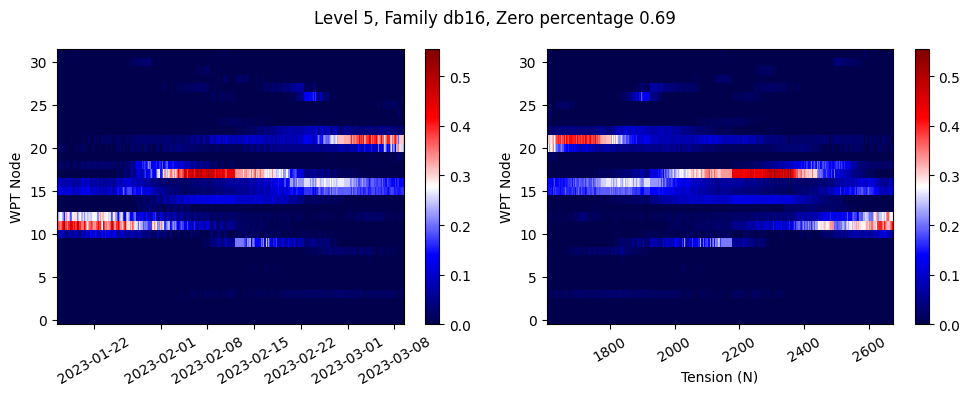

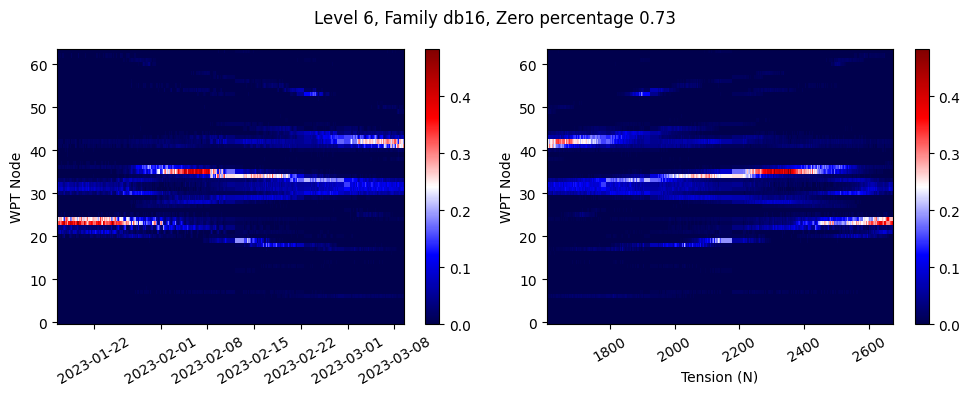

In [9]:
for family in ["haar", "db4", "db16"]:
    for level in range(3,7):
        plt.figure(figsize=(10,4))
        fe = WPTFeatureExtractor(level=level, family=family, reduction="energy", normalize=True, threshold=0.95)
        test = fe.transform(x)
        zero_coef = np.sum(test==0) / (test.shape[0]*test.shape[1])

        plt.subplot(1,2,1)
        plt.pcolormesh(dates, np.arange(test.shape[1]), test.T, cmap="seismic")
        plt.xticks(rotation=30);
        plt.ylabel("WPT Node");
        plt.colorbar();

        plt.subplot(1,2,2)
        plt.pcolormesh(y, np.arange(test.shape[1]), test.T, cmap="seismic")
        plt.xticks(rotation=30);
        plt.ylabel("WPT Node");
        plt.xlabel("Tension (N)");
        plt.colorbar();
        plt.suptitle(f"Level {level}, Family {family}, Zero percentage {np.round(zero_coef,2)}")
        plt.tight_layout()

# Example: hyperparameters tuning

In [68]:
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVR
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV

In [69]:
# pipeline = Pipeline(
#     [
#         ("feature", WPTFeatureExtractor(normalize=True)),
#         ("reduction", PCAModel(cumulative=0.99))
#     ]
# )

# params_grid = {
#     "feature__family": ["haar", "db4", "db16"],
#     "feature__level": [3,4,5],
# }

# x_train = x[0:]
# y_train = y[0:].flatten()

In [70]:
# del dataset_per_cable

In [71]:
# pipeline.fit(x_train, y_train)

Pipeline(steps=[('feature', WPTFeatureExtractor(normalize=True)),
                ('reduction', PCAModel(cumulative=0.99))])